# Analytics

## Import

In [6]:
import os
import sys
import logging
import multiprocessing
import pandas as pd
import numpy as np
import sqlalchemy
import exchange_calendars as xcals
from dotenv import load_dotenv

# import exchange_calendars as xcals
from datetime import datetime, timedelta

# import pytz
# import pandas as pd
# from IPython.display import display, HTML
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import insert, TEXT
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

# Disable logging messages unless there is an error
set_log_level("ERROR")

# from prophet.plot import (
#     plot_plotly,
#     plot_components_plotly,
#     add_changepoints_to_plot,
#     plot_yearly,
#     plot_seasonality_plotly,
# )

## Init

In [2]:
load_dotenv()  # take environment variables from .env.

module_path = os.getenv("LOCAL_AKSHARE_DEV_MODULE")
if module_path is not None and module_path not in sys.path:
    sys.path.insert(0, module_path)
import akshare as ak  # noqa: E402

print(ak.__version__)

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# Create an engine instance
alchemyEngine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}",
    pool_recycle=3600,
)

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

file_handler = logging.FileHandler("etl.log")
console_handler = logging.StreamHandler()

# Step 4: Create a formatter
formatter = logging.Formatter("%(name)s - %(levelname)s - %(message)s")

# Step 5: Attach the formatter to the handlers
file_handler.setFormatter(formatter)
console_handler.setFormatter(formatter)

# Step 6: Add the handlers to the logger
logger.addHandler(file_handler)
logger.addHandler(console_handler)

xshg = xcals.get_calendar("XSHG")

1.13.16


## Helper Functions

In [16]:
def predict(
    symbol,
    y_column,
    country=None,
    epochs=None,
    freq="B",
    random_seed=7,
    early_stopping=True,
    **kwargs,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    return predict_generic(
        "fund_etf_daily_em",
        symbol,
        y_column,
        country,
        epochs,
        freq,
        random_seed,
        early_stopping,
        **kwargs,
    )


def predict_generic(
    table,
    symbol,
    y_column,
    country=None,
    epochs=None,
    freq="B",
    random_seed=7,
    early_stopping=True,
    **kwargs,
) -> (NeuralProphet, pd.DataFrame, pd.DataFrame):  # type: ignore
    query = f"SELECT date, {y_column} FROM {table} where symbol = '{symbol}' order by date"
    df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

    df = df.rename(
        columns={
            "date": "ds",
            y_column: "y",
        }
    )

    set_random_seed(random_seed)

    m = NeuralProphet(
        **kwargs
    )  # Prophet object can only be fit once. Instantiate a new object.
    if country is not None:
        m.add_country_holidays(country_name=country)
    m.fit(
        df,
        epochs=epochs,
        early_stopping=early_stopping,
        progress=None,
        freq=freq,
    )

    future = m.make_future_dataframe(df, n_historic_predictions=True, periods=366)
    forecast = m.predict(future)

    return (m, df, forecast)

## Asset 1: Bond

### Trial 1 - Bond IR Spread

#### load data from table

In [ ]:
# load all records from `bond_metrics_em` table into dataframe
query = "SELECT * FROM bond_metrics_em where china_yield_2y <> 'NaN'"
df = pd.read_sql(query, alchemyEngine, parse_dates=["date"])

# Display the first few rows of the dataframe
df.head()

In [ ]:
df.describe()

#### transform DF to Prophet schema

In [ ]:
df = df.rename(
    columns={
        "date": "ds",
        "china_yield_spread_10y_2y": "y",
        "us_yield_spread_10y_2y": "cov",
    }
)
# df = df[["ds", "y", "cov"]]
# fig = df.plot(x="ds", y=["y", "cov"], figsize=(10, 6))
df = df[["ds", "y"]]
fig = df.plot(x="ds", y=["y"], figsize=(10, 6))

#### fitting

In [ ]:
confidence_level = 0.9

boundaries = round((1 - confidence_level) / 2, 2)
# NeuralProphet only accepts quantiles value in between 0 and 1
quantiles = [boundaries, confidence_level + boundaries]

m = NeuralProphet(
    quantiles=quantiles,
    # Disable change trendpoints
    n_changepoints=50,
    # Disable seasonality components
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    ar_layers=[32, 32, 32, 32],
    n_lags=10,
)

# m.add_lagged_regressor("cov", n_lags=3)
# m = m.add_country_holidays("CN")

train_df, test_df = m.split_df(df, freq="D", valid_p=1.0 / 16)
train_df, cal_df = m.split_df(train_df, freq="D", valid_p=1.0 / 16)

train_df.shape, cal_df.shape, test_df.shape

In [ ]:
metrics = m.fit(train_df, freq="D")
metrics

In [ ]:
test_metrics = m.test(test_df)
test_metrics

#### predicting

In [ ]:
future = m.make_future_dataframe(test_df, n_historic_predictions=True, periods=365)
forecast = m.predict(future)

#### plotting

In [ ]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

In [ ]:
m.plot_components(
    forecast,
    components=[
        "trend",
        "seasonality",
        "autoregression",
        "uncertainty",
        #   "lagged_regressors"
    ],
)

In [ ]:
m.plot_parameters(
    components=["trend", "seasonality", "autoregression", 
                # "lagged_regressors"
                ]
)

#### Conformal Predict

In [ ]:
method = "cqr"  # naive / cqr. ref: https://neuralprophet.com/how-to-guides/feature-guides/uncertainty_quantification.html
alpha = 1 - confidence_level

cfm_forecast = m.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)

In [ ]:
cfm_forecast

In [ ]:
# naive_qhat =   naive_forecast.iloc[-1]["yhat1"] - naive_forecast.iloc[-1]["yhat1 - qhat1"]
# naive_qhat

In [ ]:
m.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cfm_forecast, plotting_backend="plotly"
)

### 城投债ETF 511220

In [ ]:
symbol = "511220"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
symbol = "511220"
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 30年国债ETF 511090

In [ ]:
symbol = "511090"
m, df, forecast = predict(symbol, 'close')

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
fig2 = m.plot_components(forecast)

## Asset 2: Domestic Stock

### 创业板50ETF 159949

In [ ]:
symbol = "159949"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
symbol = "159949"
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 红利低波50ETF 515450

In [ ]:
symbol = "515450"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
plot_seasonality_plotly(m=m, name="yearly", figsize=(1200, 400))

In [ ]:
# plot_components_plotly(m, forecast)
m, df, forecast = predict(symbol, "change_rate", country="China")
plot_components_plotly(m, forecast)
# plot_seasonality_plotly(m=m, name="yearly", figsize=(1200, 400))

### 红利低波100ETF 515100

In [ ]:
symbol = "515100"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
# plot_components_plotly(m, forecast)
plot_seasonality_plotly(m=m, name="yearly", figsize=(1200, 400))

In [ ]:
m.predictive_samples(forecast)

## Asset 3: Commodities

### 黄金ETF 518880

In [ ]:
symbol = "518880"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 大宗商品ETF 510170

In [ ]:
symbol = "510170"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
symbol = "510170"
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 能源ETF 159930

In [ ]:
symbol = "159930"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 能源化工ETF 159981

In [ ]:
symbol = "159981"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

### 豆粕 159985

In [ ]:
symbol = "159985"
m, df, forecast = predict(symbol, "close")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict(symbol, "change_rate")
plot_components_plotly(m, forecast)

## Asset 4: Overseas

### 纳斯达克100 513110

In [ ]:
symbol = ".IXIC"
table = "us_index_daily_sina_view"
# we need to use the US index instead of ETF daily historical data per se, due to insufficient ETF market data
m, df, forecast = predict_generic(table, symbol, "close", "US")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
m, df, forecast = predict_generic(table, symbol, "change_rate", "US")
plot_components_plotly(m, forecast)

### 标普500ETF 513500

In [ ]:
symbol = "513500"
m, df, forecast = predict(symbol, "close", "US")
df.describe()

In [ ]:
plot_plotly(m, forecast)

In [ ]:
symbol = "513500"
m, df, forecast = predict(symbol, "change_rate", "US")
plot_components_plotly(m, forecast)

### 日本东证指数ETF 513800

In [17]:
symbol = "513800"
m, df, forecast = predict(
    symbol,
    "change_rate",
    "JP",
    weekly_seasonality=False,
    daily_seasonality=False,
    impute_missing=True,
)
df.describe()

Finding best initial lr:   0%|          | 0/227 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/data/split.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, future_df])



,ds,y
count,1166,1166.000000
mean,2021-11-15 11:53:49.502572800,0.036775
min,2019-06-25 00:00:00,-5.340000
25%,2020-09-01 06:00:00,-0.510000
50%,2021-11-16 12:00:00,0.080000
75%,2023-01-31 18:00:00,0.600000
max,2024-04-12 00:00:00,4.870000
std,NaN,1.048910


In [18]:
m.set_plotting_backend("plotly")
m.highlight_nth_step_ahead_of_each_forecast(1)
m.plot(forecast)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:100: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ds = fcst["ds"].dt.to_pydatetime()



In [19]:
m.plot_components(
    forecast,
)

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result




In [20]:
m.plot_parameters()

WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:237: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:271: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


WARNING - (py.warnings._showwarnmsg) - /Users/jx/.pyenv/versions/3.12.2/envs/venv_3.12.2/lib/python3.12/site-packages/neuralprophet/plot_model_parameters_plotly.py:475: Futur

In [21]:
yearly_seasonality = forecast[["ds", "season_yearly"]]
print(yearly_seasonality)

             ds  season_yearly
0    2019-06-25      -0.069027
1    2019-06-26      -0.063898
2    2019-06-27      -0.058634
3    2019-06-28      -0.053303
4    2019-07-01      -0.037775
...         ...            ...
1527 2025-09-02      -0.303163
1528 2025-09-03      -0.340405
1529 2025-09-04      -0.378438
1530 2025-09-05      -0.417031
1531 2025-09-08      -0.534032

[1532 rows x 2 columns]


In [23]:
# filter yearly_seasonality (which is a dataframe) by `ds` (which is a date column in format yyyy-MM-dd).
# get all records with ds in 15-Apr no matter the year.
filtered_data = yearly_seasonality[yearly_seasonality['ds'].dt.strftime('%d-%b') == '15-Apr']
print(filtered_data)

             ds  season_yearly
197  2020-04-15       0.195375
440  2021-04-15       0.190219
682  2022-04-15       0.185158
1166 2024-04-15       0.195382
1427 2025-04-15       0.190253


In [26]:
# filter yearly_seasonality by `ds` (which is a date column).
# get the rows with date range 2024-04-15 to 2025-04-14, both inclusive.
filtered_df = yearly_seasonality[
    (yearly_seasonality["ds"] >= "2024-04-15")
    & (yearly_seasonality["ds"] <= "2025-04-14")
]
filtered_df

,ds,season_yearly
1166,2024-04-15,0.195382
1167,2024-04-16,0.216942
1168,2024-04-17,0.239760
1169,2024-04-18,0.263565
1170,2024-04-19,0.288213
...,...,...
1422,2025-04-08,0.093924
1423,2025-04-09,0.101069
1424,2025-04-10,0.110624
1425,2025-04-11,0.122418


In [28]:
filtered_df['symbol'] = symbol
filtered_df.rename(columns={
    'ds': 'date',
    'season_yearly': 'coefficient',
}, inplace=True)
with alchemyEngine.begin() as conn:
    filtered_df.to_sql("ft_yearly_params", conn, if_exists="append", index=False)

WARNING - (py.warnings._showwarnmsg) - /var/folders/fb/phz99gmn7cld34rh4f6ppmlw0000gn/T/ipykernel_71639/248313590.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - /var/folders/fb/phz99gmn7cld34rh4f6ppmlw0000gn/T/ipykernel_71639/248313590.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




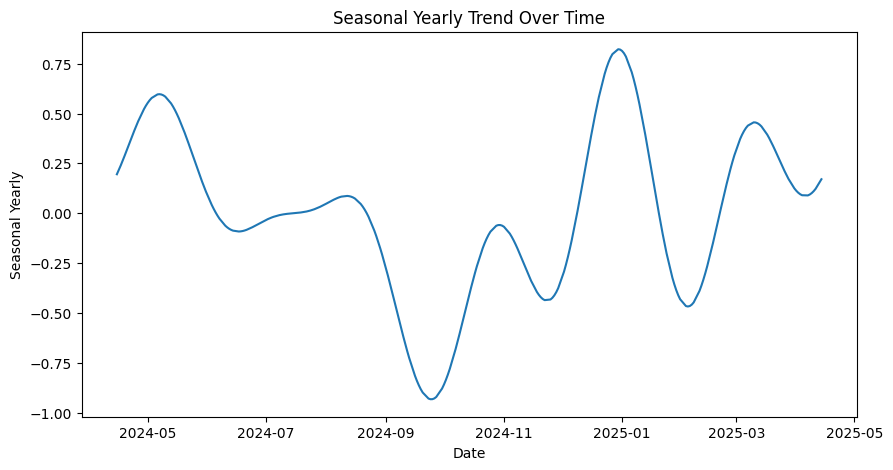

In [30]:
# plot the graph based on `filtered_df`. x axis is `date` column which is dates, y axis is `season_yearly` which is float numbers.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(filtered_df["date"], filtered_df["coefficient"])
plt.xlabel('Date')
plt.ylabel('Seasonal Yearly')
plt.title('Seasonal Yearly Trend Over Time')
plt.show()

# Output top-N TS component graph with highest Sortino Ratio

In [ ]:
top_n = 100
since_inception = "6 months"
query = f"""
    SELECT fundcode, fundname, sortinoratio sortino 
    FROM fund_etf_perf_em 
    where 
        sortinoratio is not null 
        and sortinoratio <> 'nan'
        and inceptiondate <= CURRENT_DATE - interval '{since_inception}'
    order by sortinoratio desc limit {top_n}
"""
df = pd.read_sql(query, alchemyEngine)

# Ensure the directory for saving images exists
output_dir = '/Users/jx/Downloads/ETF_forecast'
os.makedirs(output_dir, exist_ok=True)

for index, row in df.iterrows():
    fundcode = row['fundcode']
    fundname = row['fundname'].replace(' ', '_')  # Replace spaces with underscores for filename
    sortino = row['sortino']
    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

    # Predict and forecast 'close'
    m, df, forecast = predict(fundcode, 'close')
    fig1 = m.plot(forecast)
    fig1.savefig(f'{output_dir}/{fundcode}_{fundname}_{sortino}_forecast_{timestamp}.png')

    # Predict and forecast 'change_rate'
    m, df, forecast = predict(fundcode, 'change_rate')
    fig2 = m.plot_components(forecast)
    fig2.savefig(f'{output_dir}/{fundcode}_{fundname}_{sortino}_components_{timestamp}.png')